In [102]:
%%time

# Import dask
import dask

# Use dask jobqueue
from dask_jobqueue import PBSCluster

# Import a client
from dask.distributed import Client

# Setup your PBSCluster
cluster = PBSCluster(
    cores=1, # The number of cores you want
    memory='100GB', # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='/glade/scratch/${USER}/dask/casper-dav/local-dir', # Use your local directory
    resource_spec='select=1:ncpus=1:mem=100GB', # Specify resources
    project='UMAL0005', # Input your project ID here
    walltime='22:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up # of nodes
#cluster.scale(4)
cluster.adapt(minimum=1, maximum=100, wait_count=60)

# Change your url to the dask dashboard so you can see it
dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})



# Setup your client
client = Client(cluster)



import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from metpy.units import units
from metpy.plots import SkewT
import metpy.calc as mpcalc
from metpy.units import pandas_dataframe_to_unit_arrays
import cartopy.crs as ccrs
#from openpyxl import load_workbook                          #commented in my-npl-ml

import xarray as xr
#import dask.array as da
#import dask

import warnings
warnings.filterwarnings('ignore')




data_output3=xr.open_dataset('/glade/work/afallah/data/masked_SM_OL_198009_weekly.nc')    #xr.open_dataarray  #based on weekly
#data_output3.SoilMoist_tavg.isel(time=200).plot()

soil_moisture = data_output3.SoilMoist_tavg

SM5_US_point = soil_moisture.load()
SM5_US_point = SM5_US_point.persist()



CPU times: user 135 ms, sys: 375 ms, total: 510 ms
Wall time: 751 ms


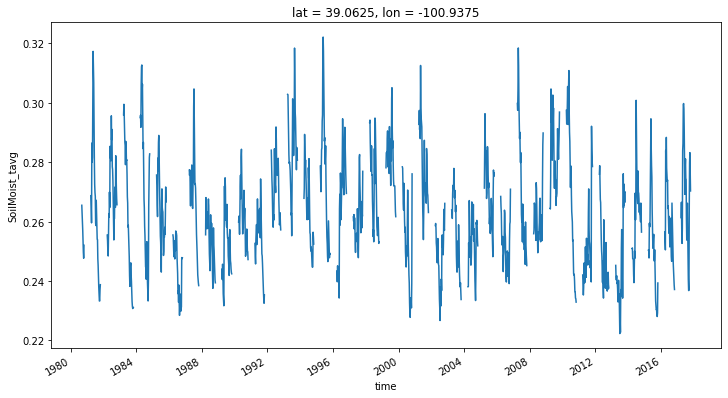

In [2]:
SM5_US_point.sel(lon=-100.9375,lat=39.0625).plot(aspect=2, size=6) 


In [38]:
SM5_US_point.isel(time=59+53+52+52+52+52+52+53+52+52+52+52+53+52+52+52+52+52+53+52+52+52+52+53+52+52+52+52+52+53+52+52+52+52+52+53+52)

<xarray.DataArray 'SoilMoist_tavg' (lat: 224, lon: 464)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * lat      (lat) float64 25.06 25.19 25.31 25.44 ... 52.56 52.69 52.81 52.94
  * lon      (lon) float64 -124.9 -124.8 -124.7 -124.6 ... -67.31 -67.19 -67.06
    time     datetime64[ns] 2017-10-29
Attributes:
    grid_mapping:  spatial_ref

In [103]:


%%time

import warnings
warnings.filterwarnings('ignore')
#warnings.filterwarnings(action='once')


#ATTENTION: This is based on weeks not pentads!



def flashdrought(SM5_US_point):
    
    #####################SM5_US_point = SM5_US_point[0:2648]
    
    #Duration_FD = np.zeros((14, 38))    #RELATED TO ERROR SIZES
    #Frequency_FD = np.zeros((14, 38))
    #Severity_FD = np.zeros((14, 38))
    FD = []
    #index = []
    Dur_FD = []    #Events less than 40 percentile 
    Sev_FD = []    #deficit in SM from 40 percentile 
    #S = []
    Freq_FD = []
    L = []
    Fr = []
    SM_q20 = np.nanquantile(SM5_US_point, [0.20])   #no growing season are nan
    SM_q40 = np.nanquantile(SM5_US_point, [0.40])
    
    ######SM5_US_point_1979 = SM5_US_point[round((2006-1981)*12*30/5+1*30/5):round(12*30/5+round((2014-1981)*12*30/5+4*30/5))] 
    
    #SM5_US_point.flags.writeable = True
    #SM5_US_point[round((2017-1981)*12*30/5+1*30/5):round(7*30/5+round((2017-1981)*12*30/5+1*30/5))] = -999     #First 43 pentads have to NA to exclude them from our calculation; those are in past year (2011) 
    #SM5_US_point_1979 = SM5_US_point[round((2017-1981)*12*30/5+1*30/5):round(12*30/5+round((2017-1981)*12*30/5+4*30/5))]    #only computes FD char. 2012, months 4-10
    #OLD#SM5_US_point_1979 = SM5_US_point[round((2012-1981)*12*30/5+5*30/5):round(12*30/5+round((2012-1981)*12*30/5+8*30/5))]    #only computes FD char. 2012, months 4-10     #remove it later for entire year 2012
    SM5_US_point_1979 = SM5_US_point
    
    
    index = np.zeros((SM5_US_point_1979.size)+31)#,dtype=np.object)
    fd = np.zeros(SM5_US_point_1979.size-1+31)
    fd_DROUGHT = np.zeros(SM5_US_point_1979.size-1+31)
    onset_drought = np.zeros(SM5_US_point_1979.size-1+31)   #not sure 
    S = np.zeros(SM5_US_point_1979.size-1+31)
    onset = np.zeros(SM5_US_point_1979.size-1+31)
    onset_20 = np.zeros(SM5_US_point_1979.size-1+31)
    du = np.zeros(SM5_US_point_1979.size-1+31)

    for i in range(31, (SM5_US_point_1979.size-1)):
 

        #here1
        if SM5_US_point_1979[i-2] <=  SM_q20 and SM5_US_point_1979[i-1] <=  SM_q20 and SM5_US_point_1979[i] <=  SM_q20: #two weeks below 20 percentile!  #duration is at least 2 weeks 


            #if SM5_US_point_1979[i-2] >= SM_q40:
            #    #L=2
            #    S[i-1] = SM5_US_point_1979[i-1] - SM_q40
            #    S[i] = SM5_US_point_1979[i] - SM_q40

            #    #fd[i-2] = 1
            #    fd[i-1] = 1
            #    fd[i] = 1

            #elif SM5_US_point_1979[i-3] >= SM_q40:
            #    #L=3
            #    S[i-2] = SM5_US_point_1979[i-2] - SM_q40
            #    S[i-1] = SM5_US_point_1979[i-1] - SM_q40
            #    S[i] = SM5_US_point_1979[i] - SM_q40   
                
            #   #fd[i-3] = 1
            #    fd[i-2] = 1
            #    fd[i-1] = 1
            #    fd[i] = 1

            #elif SM5_US_point_1979[i-4] >= SM_q40:
            #    #L=4
            #    S[i-3] = SM5_US_point_1979[i-3] - SM_q40
            #    S[i-2] = SM5_US_point_1979[i-2] - SM_q40
            #    S[i-1] = SM5_US_point_1979[i-1] - SM_q40
            #    S[i] = SM5_US_point_1979[i] - SM_q40
                
            #   #fd[i-4] = 1
            #    fd[i-3] = 1
            #    fd[i-2] = 1
            #    fd[i-1] = 1
            #   fd[i] = 1


            ##elif SM5_US_point_1979[i-5] >= SM_q40:
            ##    #L=6
            ##    #S=np.sum([SM5_US_point_1979[i-5] - SM5_US_point_1979[i-4] - SM_q40, SM5_US_point_1979[i-3] - SM_q40, SM5_US_point_1979[i-2] - SM_q40, SM5_US_point_1979[i-1] - SM_q40 , SM5_US_point_1979[i] - SM_q40 , SM5_US_point_1979[i+1] - SM_q40])
            ##    #Dur_FD.append(L)
            ##    #Sev_FD.append(S)
            ##    #fd[i-5] = 1
            ##    fd[i-4] = 1
            ##    fd[i-3] = 1
            ##    fd[i-2] = 1
            ##    fd[i-1] = 1
            ##    fd[i] = 1
            
            
        
            
            if SM5_US_point_1979[i-3] >= SM_q40 or SM5_US_point_1979[i-4] >= SM_q40 or SM5_US_point_1979[i-5] >= SM_q40:   
                
                #onset_20[i-2] = 1   #use onset instead of onset 20!
                fd[i-2] = 1
                fd[i-1] = 1
                fd[i] = 1
                S[i-2] = SM5_US_point_1979[i-2] - SM_q40
                S[i-1] = SM5_US_point_1979[i-1] - SM_q40
                S[i] = SM5_US_point_1979[i] - SM_q40
                
                ####FD onset; exact time falls below 20% 
                ###if SM5_US_point_1979[i-3] > SM_q40:   #before was SM_q20?
                ###    onset_20[i-2] = 1
                ###    fd[i-2] = 1
                ###    fd[i-1] = 1
                ###    fd[i] = 1
                ###    S[i-2] = SM5_US_point_1979[i-2] - SM_q40
                ###    S[i-1] = SM5_US_point_1979[i-1] - SM_q40
                ###    S[i] = SM5_US_point_1979[i] - SM_q40
                ###
                ###    
                ###elif SM5_US_point_1979[i-4] > SM_q40:  #before was SM_q20?
                ###    onset_20[i-3] = 1
                ###    fd[i-3] = 1 
                ###   fd[i-2] = 1
                ###    fd[i-1] = 1
                ###    fd[i] = 1
                ###    S[i-3] = SM5_US_point_1979[i-3] - SM_q40
                ###    S[i-2] = SM5_US_point_1979[i-2] - SM_q40
                ###    S[i-1] = SM5_US_point_1979[i-1] - SM_q40
                ###    S[i] = SM5_US_point_1979[i] - SM_q40
                ###    
                ###else:
                ###    onset_20[i-4] = 1
                ###    fd[i-4] = 1
                ###    fd[i-3] = 1
                ###    fd[i-2] = 1
                ###    fd[i-1] = 1
                ###    fd[i] = 1
                ###    S[i-4] = SM5_US_point_1979[i-4] - SM_q40
                ###    S[i-3] = SM5_US_point_1979[i-3] - SM_q40
                ###    S[i-2] = SM5_US_point_1979[i-2] - SM_q40
                ###    S[i-1] = SM5_US_point_1979[i-1] - SM_q40
                ###    S[i] = SM5_US_point_1979[i] - SM_q40
                    
                ####else:
                ####    onset_20[i-5] = 1
                ####    fd[i-5] = 1
                ####    fd[i-4] = 1
                ####    fd[i-3] = 1
                ####    fd[i-2] = 1
                ####    fd[i-1] = 1
                ####    fd[i] = 1
                    
                #FD termination    
                for k in range(i+1,SM5_US_point_1979.size-1):
                    if SM5_US_point_1979[k] < SM_q20:
                        #L = L+1
                        S[k]= SM5_US_point_1979[k] - SM_q40
                        fd[k] = 1


                    else:
                        #fd[k] = 0     #it must be commented 
                        break
                        
                        
        
    for i in range(31, (SM5_US_point_1979.size-1)):   #it requires new loop!
        
        sum=0   #duration in each event 
        
        if fd[i+1] > fd[i]: #and fd[i+2] > fd[i] and fd[i+3] > fd[i]:   #important: this condition jump to a new event!       
            onset[i+1] = 1    #represents frequency!    #onset is correct             
                    
            for k in range(i+2,SM5_US_point_1979.size-1):
                
                    
                if fd[k] == fd[k-1]:
                    sum=sum+1
                    du[k-1] = 0     #it stores the accumulation only at the end of FD
                    du[k] = sum     #since this du includes event with 1 week duration, it needs to excule those events later!
                    
                    if k == i+5:
                        onset_drought[i+5] = 1    #number of DROUGHT events (with duration >=5 weeks)   #recently added to calcluate how many percentage evended up with Drought 

                    
                    if k==59 or k==112 or k==164 or k==216 or k==268 or k==320 or k==372 or k==425 or k==477 or k==529 or k==581 or k==633 or k==686 or k==738 or k==790 or k==842 or k==894 or k==946 or k==999 or k==1051 or k==1103 or k==1155 or k==1207 or k==1260 or k==1312 or k==1364 or k==1416 or k==1468 or k==1520 or k==1573 or k==1625 or k==1677 or k==1729 or k==1781 or k==1833 or k==1886 or k==1937:
                        break

                else:
                    break 
                        
                        
                    
            
            
          
        
            
        

    
    #Duration_FD = np.nanmean(Dur_FD)
    ##print(Dur_FD)
    #print(Sev_FD)
    #Frequency_FD = len(Dur_FD)
    #Severity_FD = -1*np.nanmean(Sev_FD)  #ValueError: setting an array element with a sequence   #sum? 
    
    #return fd
    #return S
    #return onset
    #return onset_drought
    return du
     
    



client


#if k==1937 or k==1937-52*1 or k==1937-52*2 or k==1937-52*3 or k==1937-52*4 or k==1937-52*5 or k==1937-52*6 or k==1937-52*7 or k==1937-52*8 or k==1937-52*9 or k==1937-52*10 or k==1937-52*11 or k==1937-52*12 or k==1937-52*13 or k==1937-52*14 or k==1937-52*15 or k==1937-52*16 or k==1937-52*17 or k==1937-52*18 or k==1937-52*19 or k==1937-52*20 or k==1937-52*21 or k==1937-52*22 or k==1937-52*23 or k==1937-52*24 or k==1937-52*25 or k==1937-52*26 or k==1937-52*27 or k==1937-52*28 or k==1937-52*29 or k==1937-52*30 or k==1937-52*31 or k==1937-52*32 or k==1937-52*33 or k==1937-52*34 or k==1937-52*35 or 1937-52*36:                       


CPU times: user 65 µs, sys: 0 ns, total: 65 µs
Wall time: 71 µs


<Client: 'tcp://10.12.206.65:46313' processes=0 threads=0, memory=0 B>

In [104]:
%%time

##import bottleneck
##Frequency_FD = xr.apply_ufunc(flashdrought, SM5_US_point, input_core_dims=[["time"]], dask = 'allowed', vectorize = True)      #the only issue for apply_ufunc is na! this is the case for both flashdrought3 and flashdrought!!!!!!!!!!!!!!!!!!!! Solve first for flashdrought3!!!!!!!!!   Reminder only dask: -1 according to stackoverflow!!!
##client


#three_dim = xr.apply_ufunc(flashdrought, SM5_US_point, input_core_dims=[["time"]], output_core_dims=[["time_new"]], dask = 'allowed', vectorize = True).rename({'time_new': 'time'})      #the only issue for apply_ufunc is na! this is the case for both flashdrought3 and flashdrought!!!!!!!!!!!!!!!!!!!! Solve first for flashdrought3!!!!!!!!!   Reminder only dask: -1 according to stackoverflow!!!

#Severity = xr.apply_ufunc(flashdrought, SM5_US_point, input_core_dims=[["time"]], output_core_dims=[["time_new"]], dask = 'allowed', vectorize = True).rename({'time_new': 'time'})      #the only issue for apply_ufunc is na! this is the case for both flashdrought3 and flashdrought!!!!!!!!!!!!!!!!!!!! Solve first for flashdrought3!!!!!!!!!   Reminder only dask: -1 according to stackoverflow!!!

#onset = xr.apply_ufunc(flashdrought, SM5_US_point, input_core_dims=[["time"]], output_core_dims=[["time_new"]], dask = 'allowed', vectorize = True).rename({'time_new': 'time'})      #the only issue for apply_ufunc is na! this is the case for both flashdrought3 and flashdrought!!!!!!!!!!!!!!!!!!!! Solve first for flashdrought3!!!!!!!!!   Reminder only dask: -1 according to stackoverflow!!!

#onset_drought = xr.apply_ufunc(flashdrought, SM5_US_point, input_core_dims=[["time"]], output_core_dims=[["time_new"]], dask = 'allowed', vectorize = True).rename({'time_new': 'time'})      #the only issue for apply_ufunc is na! this is the case for both flashdrought3 and flashdrought!!!!!!!!!!!!!!!!!!!! Solve first for flashdrought3!!!!!!!!!   Reminder only dask: -1 according to stackoverflow!!!

Duration = xr.apply_ufunc(flashdrought, SM5_US_point, input_core_dims=[["time"]], output_core_dims=[["time_new"]], dask = 'allowed', vectorize = True).rename({'time_new': 'time'})      #the only issue for apply_ufunc is na! this is the case for both flashdrought3 and flashdrought!!!!!!!!!!!!!!!!!!!! Solve first for flashdrought3!!!!!!!!!   Reminder only dask: -1 according to stackoverflow!!!

client

#Add this for three_dim related to FD index2 
# output_core_dims=[["time"]],

CPU times: user 11min 58s, sys: 21.2 s, total: 12min 19s
Wall time: 12min 54s


<Client: 'tcp://10.12.206.65:46313' processes=1 threads=1, memory=100.00 GB>

In [105]:
#t_new = DA5_US.time[0:2715]
lat = np.linspace(25.0625, 52.9375 , num=224)
lon = np.linspace(-124.9375, -67.0625 , num=464)

#binary = xr.DataArray(data=three_dim.isel(time=slice(0,three_dim.time.size-31+1)), dims=["lat", "lon","time"], coords=[lat,lon,SM5_US_point.time])

#binary_sev = xr.DataArray(data=Severity.isel(time=slice(0,Severity.time.size-31+1)), dims=["lat", "lon","time"], coords=[lat,lon,SM5_US_point.time])

#binary_onset = xr.DataArray(data=onset.isel(time=slice(0,onset.time.size-31+1)), dims=["lat", "lon","time"], coords=[lat,lon,SM5_US_point.time])

#binary_onset_drought = xr.DataArray(data=onset_drought.isel(time=slice(0,onset_drought.time.size-31+1)), dims=["lat", "lon","time"], coords=[lat,lon,SM5_US_point.time])

binary_dur = xr.DataArray(data=Duration.isel(time=slice(0,Duration.time.size-31+1)), dims=["lat", "lon","time"], coords=[lat,lon,SM5_US_point.time])



In [18]:
#binary_sev_norm = (binary_sev)/(binary_sev.min())*5
37.8125+5*.125

38.4375

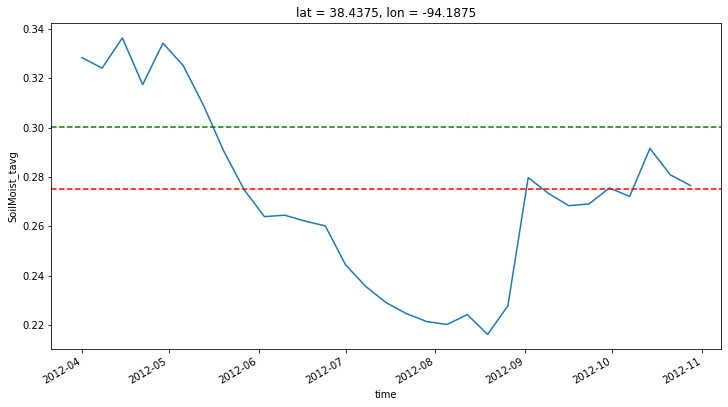

In [6]:
SM5_US_point.sel(lon=-94.1875,lat=38.4375, time=slice('2012-04-01T00:00:00.000000000','2012-10-31T00:00:00.000000000')).plot(aspect=2, size=6) 
plt.axhline(y=SM5_US_point.sel(lon=-94.1875,lat=38.4375, method="nearest").quantile([0.20], 'time'), color='r', linestyle='dashed', label='20 percentile')    #20 percentile = 29.8
plt.axhline(y=SM5_US_point.sel(lon=-94.1875,lat=38.4375, method="nearest").quantile([0.40], 'time'), color='g', linestyle='dashed', label='40 percentile')     #40 percentile = 31.2


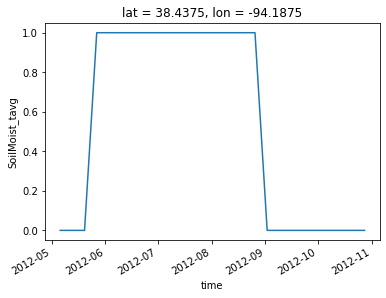

In [7]:
binary.sel(lon=-94.1875,lat=38.4375, time=slice('2012-05-01T00:00:00.000000000','2012-10-31T00:00:00.000000000')).plot()

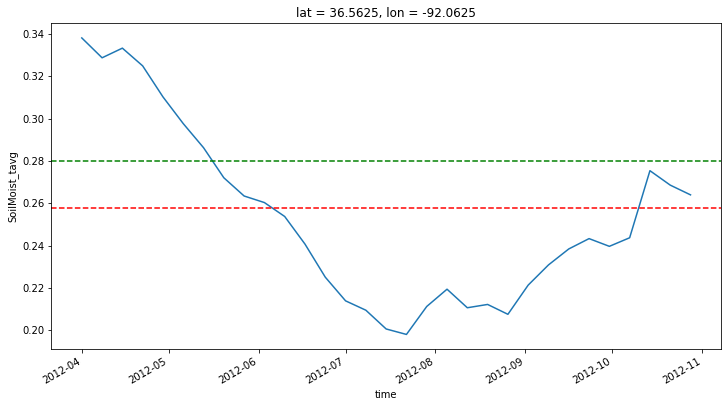

In [8]:
SM5_US_point.sel(lon=-92.0625,lat=36.5625, time=slice('2012-04-01T00:00:00.000000000','2012-10-31T00:00:00.000000000')).plot(aspect=2, size=6) 
plt.axhline(y=SM5_US_point.sel(lon=-92.0625,lat=36.5625, method="nearest").quantile([0.20], 'time'), color='r', linestyle='dashed', label='20 percentile')    #20 percentile = 29.8
plt.axhline(y=SM5_US_point.sel(lon=-92.0625,lat=36.5625, method="nearest").quantile([0.40], 'time'), color='g', linestyle='dashed', label='40 percentile')     #40 percentile = 31.2


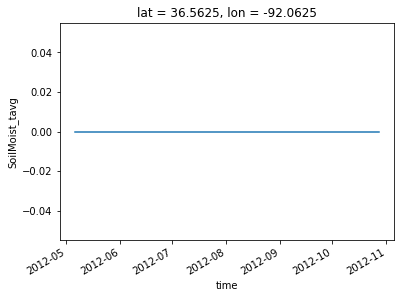

In [9]:
binary.sel(lon=-92.0625,lat=36.5625, time=slice('2012-05-01T00:00:00.000000000','2012-10-31T00:00:00.000000000')).plot()

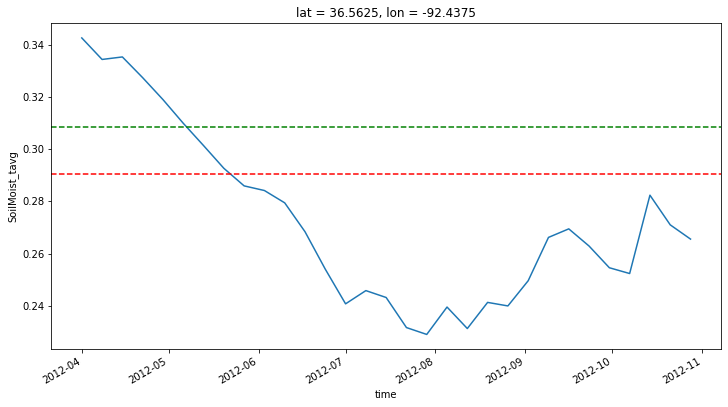

In [10]:
SM5_US_point.sel(lon=-92.4375,lat=36.5625, time=slice('2012-04-01T00:00:00.000000000','2012-10-31T00:00:00.000000000')).plot(aspect=2, size=6) 
plt.axhline(y=SM5_US_point.sel(lon=-92.4375,lat=36.5625, method="nearest").quantile([0.20], 'time'), color='r', linestyle='dashed', label='20 percentile')    #20 percentile = 29.8
plt.axhline(y=SM5_US_point.sel(lon=-92.4375,lat=36.5625, method="nearest").quantile([0.40], 'time'), color='g', linestyle='dashed', label='40 percentile')     #40 percentile = 31.2


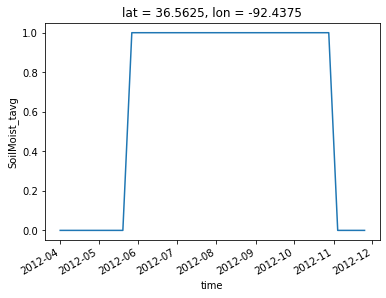

In [11]:
binary.sel(lon=-92.4375,lat=36.5625, time=slice('2012-04-01T00:00:00.000000000','2012-11-29T00:00:00.000000000')).plot()

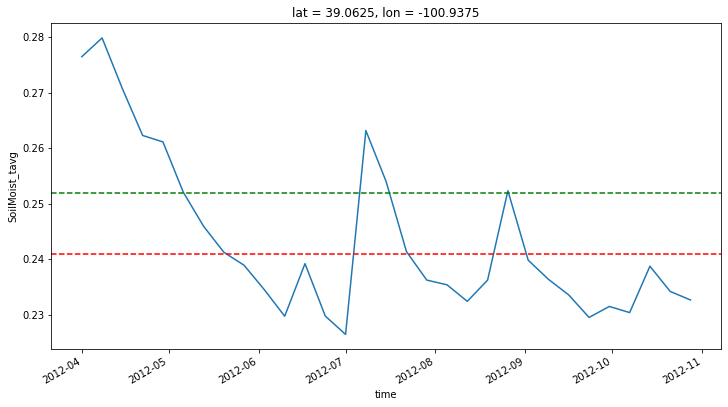

In [12]:
SM5_US_point.sel(lon=-100.9375,lat=39.0625, time=slice('2012-04-01T00:00:00.000000000','2012-10-31T00:00:00.000000000')).plot(aspect=2, size=6) 
plt.axhline(y=SM5_US_point.sel(lon=-100.9375,lat=39.0625, method="nearest").quantile([0.20], 'time'), color='r', linestyle='dashed', label='20 percentile')    #20 percentile = 29.8
plt.axhline(y=SM5_US_point.sel(lon=-100.9375,lat=39.0625, method="nearest").quantile([0.40], 'time'), color='g', linestyle='dashed', label='40 percentile')     #40 percentile = 31.2


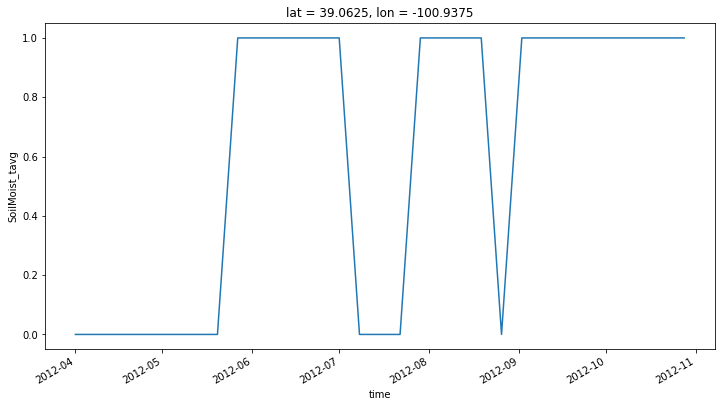

In [13]:
binary.sel(lon=-100.9375,lat=39.0625, time=slice('2012-04-01T00:00:00.000000000','2012-10-31T00:00:00.000000000')).plot(aspect=2, size=6)
#binary_sev.sel(lon=-100.9375,lat=39.0625, time=slice('2012-04-01T00:00:00.000000000','2012-10-31T00:00:00.000000000')).plot(aspect=2, size=6)
#binary_sev_norm.sel(lon=-100.9375,lat=39.0625, time=slice('2012-04-01T00:00:00.000000000','2012-10-31T00:00:00.000000000')).plot(aspect=2, size=6)


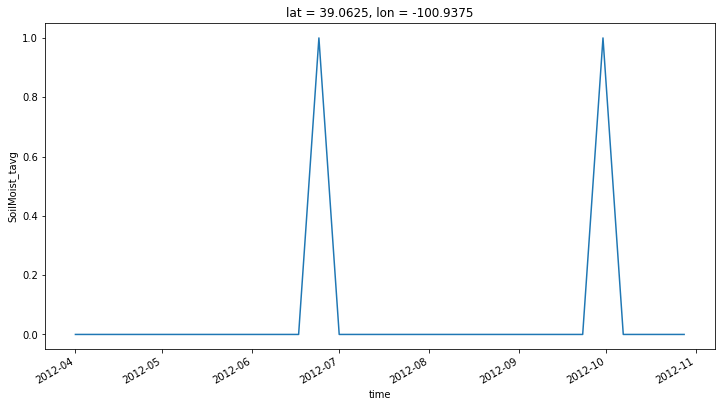

In [75]:
binary_onset_drought.sel(lon=-100.9375,lat=39.0625, time=slice('2012-04-01T00:00:00.000000000','2012-10-31T00:00:00.000000000')).plot(aspect=2, size=6)
#binary_sev.sel(lon=-100.9375,lat=39.0625, time=slice('2012-04-01T00:00:00.000000000','2012-10-31T00:00:00.000000000')).plot(aspect=2, size=6)
#binary_sev_norm.sel(lon=-100.9375,lat=39.0625, time=slice('2012-04-01T00:00:00.000000000','2012-10-31T00:00:00.000000000')).plot(aspect=2, size=6)


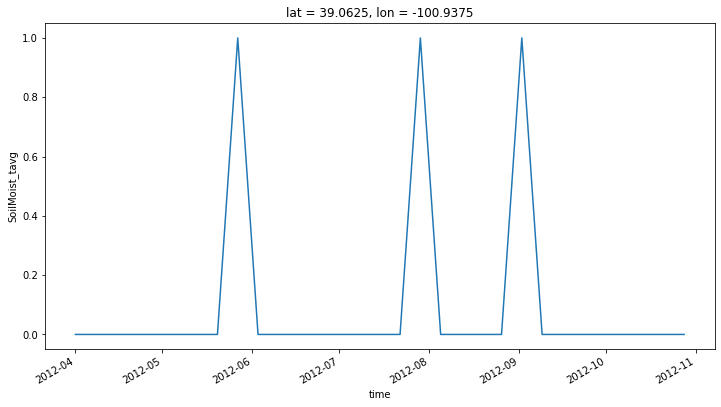

In [57]:
binary_onset.sel(lon=-100.9375,lat=39.0625, time=slice('2012-04-01T00:00:00.000000000','2012-10-31T00:00:00.000000000')).plot(aspect=2, size=6)
#binary_sev.sel(lon=-100.9375,lat=39.0625, time=slice('2012-04-01T00:00:00.000000000','2012-10-31T00:00:00.000000000')).plot(aspect=2, size=6)
#binary_sev_norm.sel(lon=-100.9375,lat=39.0625, time=slice('2012-04-01T00:00:00.000000000','2012-10-31T00:00:00.000000000')).plot(aspect=2, size=6)


In [89]:
binary_onset_20.sel(lon=-100.9375,lat=39.0625, time=slice('2012-04-01T00:00:00.000000000','2012-10-31T00:00:00.000000000')).plot(aspect=2, size=6)
#binary_sev.sel(lon=-100.9375,lat=39.0625, time=slice('2012-04-01T00:00:00.000000000','2012-10-31T00:00:00.000000000')).plot(aspect=2, size=6)
#binary_sev_norm.sel(lon=-100.9375,lat=39.0625, time=slice('2012-04-01T00:00:00.000000000','2012-10-31T00:00:00.000000000')).plot(aspect=2, size=6)


NameError: name 'binary_onset_20' is not defined

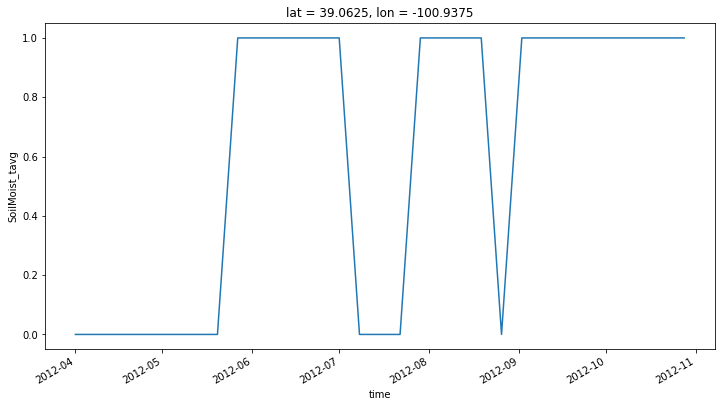

In [14]:
#test is fd has no duration!

binary.sel(lon=-100.9375,lat=39.0625, time=slice('2012-04-01T00:00:00.000000000','2012-10-31T00:00:00.000000000')).plot(aspect=2, size=6)
#binary_sev.sel(lon=-100.9375,lat=39.0625, time=slice('2012-04-01T00:00:00.000000000','2012-10-31T00:00:00.000000000')).plot(aspect=2, size=6)
#binary_sev_norm.sel(lon=-100.9375,lat=39.0625, time=slice('2012-04-01T00:00:00.000000000','2012-10-31T00:00:00.000000000')).plot(aspect=2, size=6)


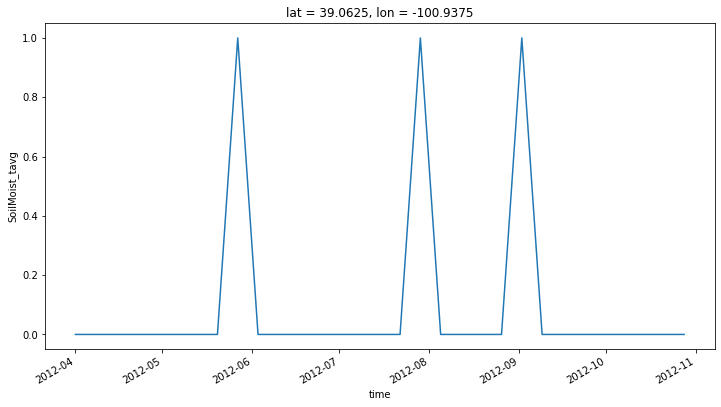

In [58]:
binary_onset.sel(lon=-100.9375,lat=39.0625, time=slice('2012-04-01T00:00:00.000000000','2012-10-31T00:00:00.000000000')).plot(aspect=2, size=6)


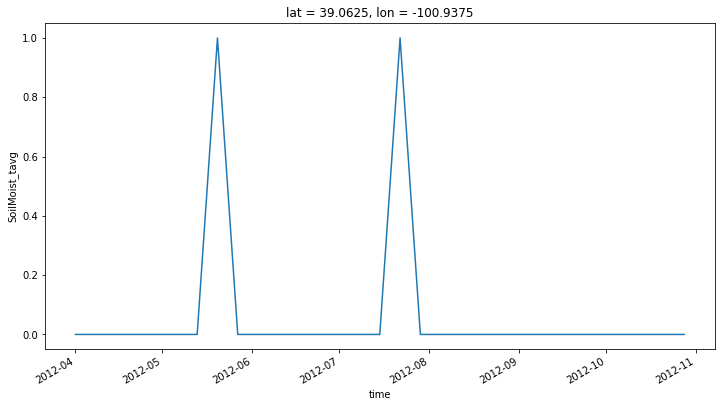

In [65]:
binary_onset_20.sel(lon=-100.9375,lat=39.0625, time=slice('2012-04-01T00:00:00.000000000','2012-10-31T00:00:00.000000000')).plot(aspect=2, size=6)


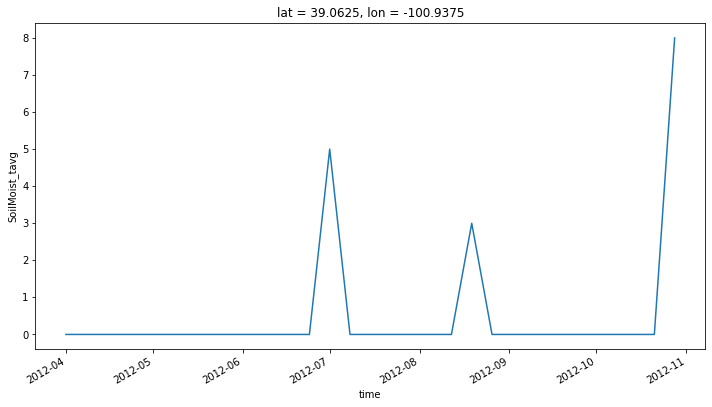

In [99]:
binary_dur.sel(lon=-100.9375,lat=39.0625, time=slice('2012-04-01T00:00:00.000000000','2012-10-31T00:00:00.000000000')).plot(aspect=2, size=6)


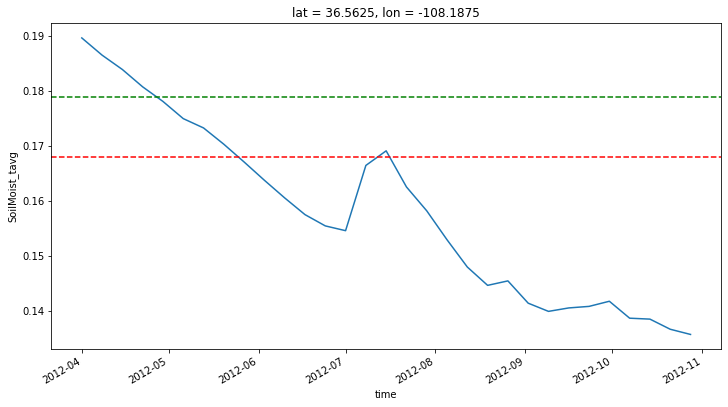

In [15]:
SM5_US_point.sel(lon=-108.1875,lat=36.5625, time=slice('2012-04-01T00:00:00.000000000','2012-10-31T00:00:00.000000000')).plot(aspect=2, size=6) 
plt.axhline(y=SM5_US_point.sel(lon=-108.1875,lat=36.5625).quantile([0.20], 'time'), color='r', linestyle='dashed', label='20 percentile')    #20 percentile = 29.8
plt.axhline(y=SM5_US_point.sel(lon=-108.1875,lat=36.5625).quantile([0.40], 'time'), color='g', linestyle='dashed', label='40 percentile')     #40 percentile = 31.2


In [60]:
#binary.sel(lon=-108.1875,lat=36.5625, time=slice('2012-04-01T00:00:00.000000000','2012-10-31T00:00:00.000000000')).plot(aspect=2, size=6)
#binary_sev.sel(lon=-108.1875,lat=36.5625, time=slice('2012-04-01T00:00:00.000000000','2012-10-31T00:00:00.000000000')).plot(aspect=2, size=6)


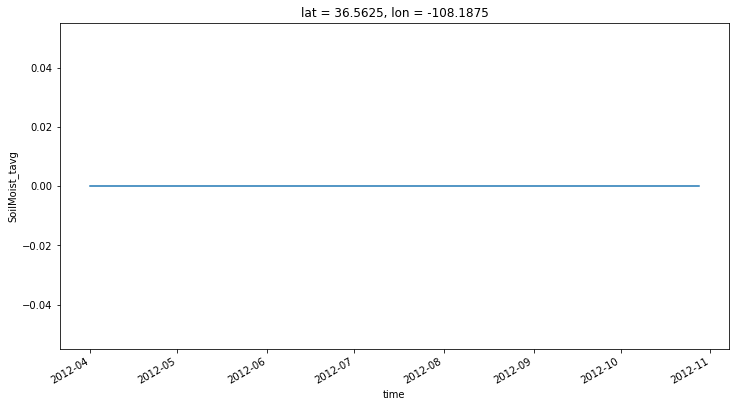

In [76]:
binary_onset_drought.sel(lon=-108.1875,lat=36.5625, time=slice('2012-04-01T00:00:00.000000000','2012-10-31T00:00:00.000000000')).plot(aspect=2, size=6)
#binary_sev.sel(lon=-108.1875,lat=36.5625, time=slice('2012-04-01T00:00:00.000000000','2012-10-31T00:00:00.000000000')).plot(aspect=2, size=6)


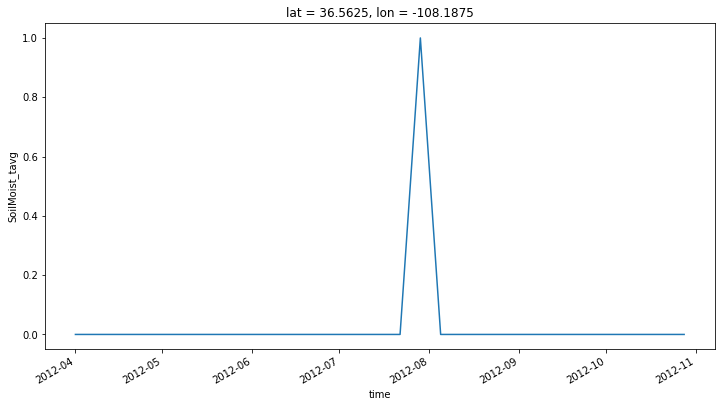

In [66]:
binary_onset_20.sel(lon=-108.1875,lat=36.5625, time=slice('2012-04-01T00:00:00.000000000','2012-10-31T00:00:00.000000000')).plot(aspect=2, size=6)
#binary_sev.sel(lon=-108.1875,lat=36.5625, time=slice('2012-04-01T00:00:00.000000000','2012-10-31T00:00:00.000000000')).plot(aspect=2, size=6)


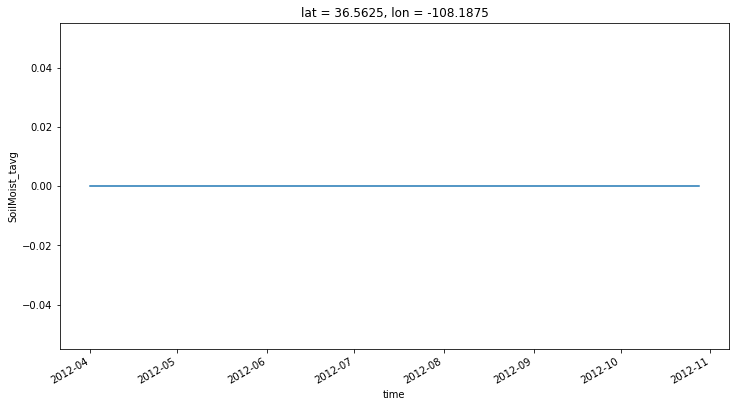

In [61]:
binary_onset.sel(lon=-108.1875,lat=36.5625, time=slice('2012-04-01T00:00:00.000000000','2012-10-31T00:00:00.000000000')).plot(aspect=2, size=6)
#binary_sev.sel(lon=-108.1875,lat=36.5625, time=slice('2012-04-01T00:00:00.000000000','2012-10-31T00:00:00.000000000')).plot(aspect=2, size=6)


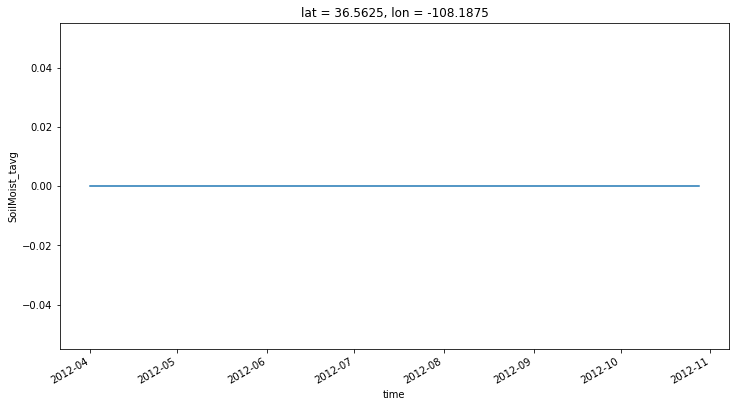

In [113]:
#test if fd has no duration

binary.sel(lon=-108.1875,lat=36.5625, time=slice('2012-04-01T00:00:00.000000000','2012-10-31T00:00:00.000000000')).plot(aspect=2, size=6)
#binary_sev.sel(lon=-108.1875,lat=36.5625, time=slice('2012-04-01T00:00:00.000000000','2012-10-31T00:00:00.000000000')).plot(aspect=2, size=6)


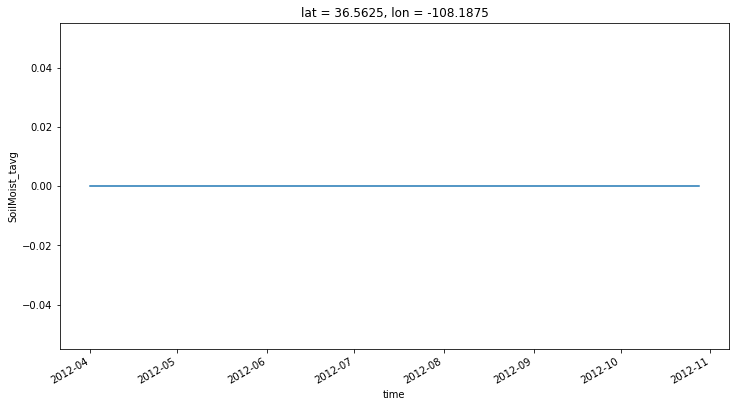

In [62]:
binary_onset.sel(lon=-108.1875,lat=36.5625, time=slice('2012-04-01T00:00:00.000000000','2012-10-31T00:00:00.000000000')).plot(aspect=2, size=6)


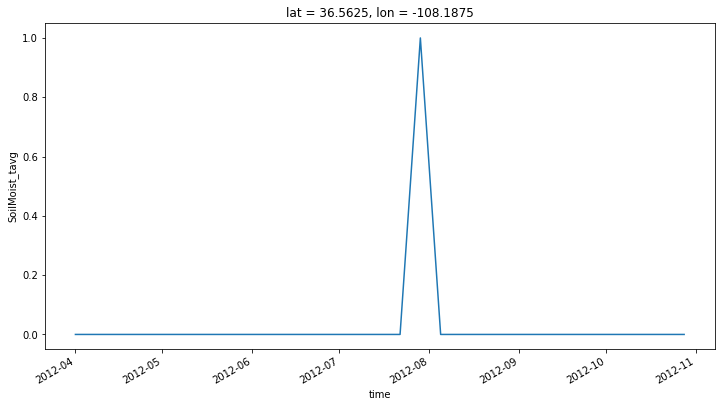

In [67]:
binary_onset_20.sel(lon=-108.1875,lat=36.5625, time=slice('2012-04-01T00:00:00.000000000','2012-10-31T00:00:00.000000000')).plot(aspect=2, size=6)


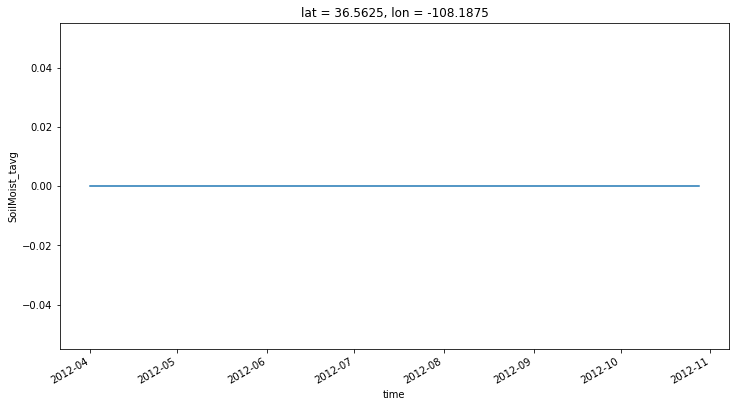

In [100]:

binary_dur.sel(lon=-108.1875,lat=36.5625, time=slice('2012-04-01T00:00:00.000000000','2012-10-31T00:00:00.000000000')).plot(aspect=2, size=6)


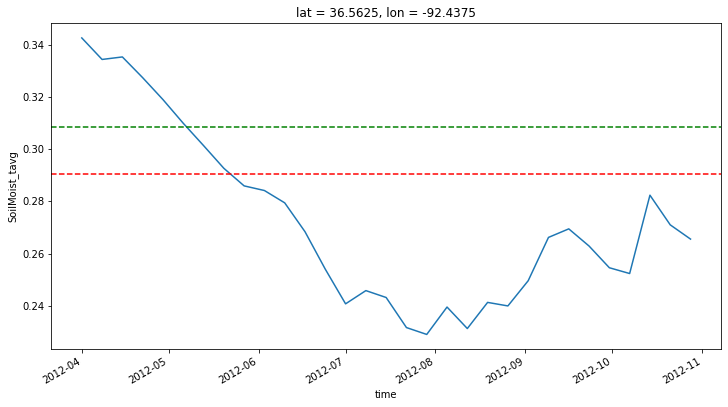

In [17]:
SM5_US_point.sel(lon=-92.4375,lat=36.5625, time=slice('2012-04-01T00:00:00.000000000','2012-10-31T00:00:00.000000000')).plot(aspect=2, size=6) 
plt.axhline(y=SM5_US_point.sel(lon=-92.4375,lat=36.5625, method="nearest").quantile([0.20], 'time'), color='r', linestyle='dashed', label='20 percentile')    #20 percentile = 29.8
plt.axhline(y=SM5_US_point.sel(lon=-92.4375,lat=36.5625, method="nearest").quantile([0.40], 'time'), color='g', linestyle='dashed', label='40 percentile')     #40 percentile = 31.2


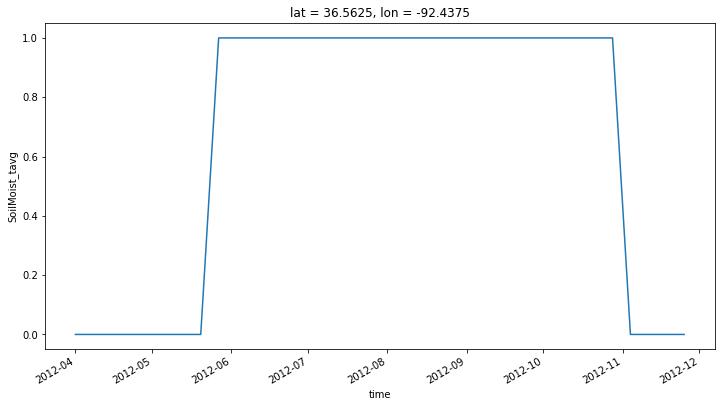

In [18]:
binary.sel(lon=-92.4375,lat=36.5625, time=slice('2012-04-01T00:00:00.000000000','2012-11-29T00:00:00.000000000')).plot(aspect=2, size=6)
#binary_sev.sel(lon=-92.4375,lat=36.5625, time=slice('2012-04-01T00:00:00.000000000','2012-10-31T00:00:00.000000000')).plot(aspect=2, size=6)


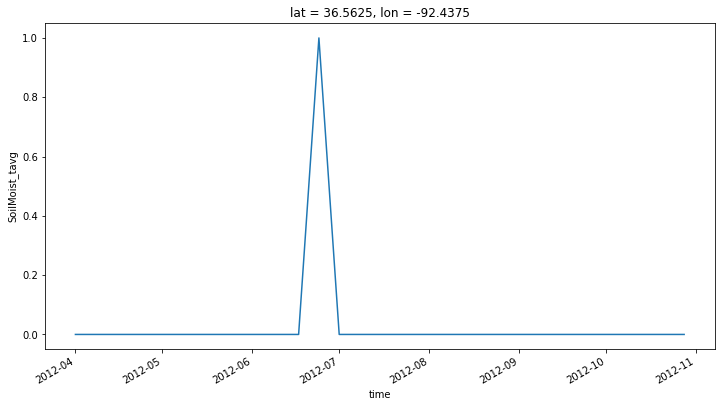

In [77]:
binary_onset_drought.sel(lon=-92.4375,lat=36.5625, time=slice('2012-04-01T00:00:00.000000000','2012-10-31T00:00:00.000000000')).plot(aspect=2, size=6)
#binary_sev.sel(lon=-92.4375,lat=36.5625, time=slice('2012-04-01T00:00:00.000000000','2012-10-31T00:00:00.000000000')).plot(aspect=2, size=6)


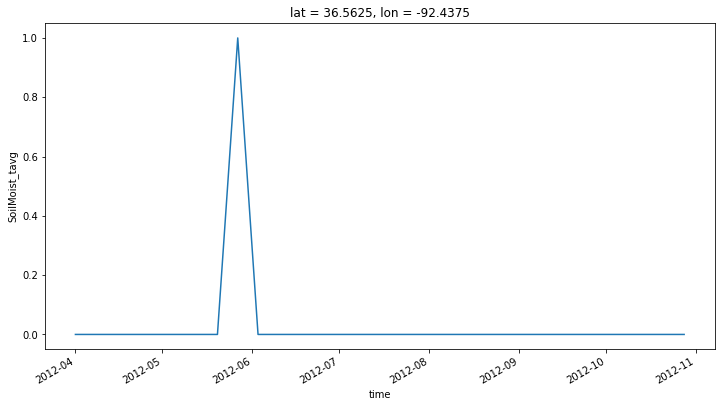

In [68]:
binary_onset_20.sel(lon=-92.4375,lat=36.5625, time=slice('2012-04-01T00:00:00.000000000','2012-10-31T00:00:00.000000000')).plot(aspect=2, size=6)
#binary_sev.sel(lon=-92.4375,lat=36.5625, time=slice('2012-04-01T00:00:00.000000000','2012-10-31T00:00:00.000000000')).plot(aspect=2, size=6)


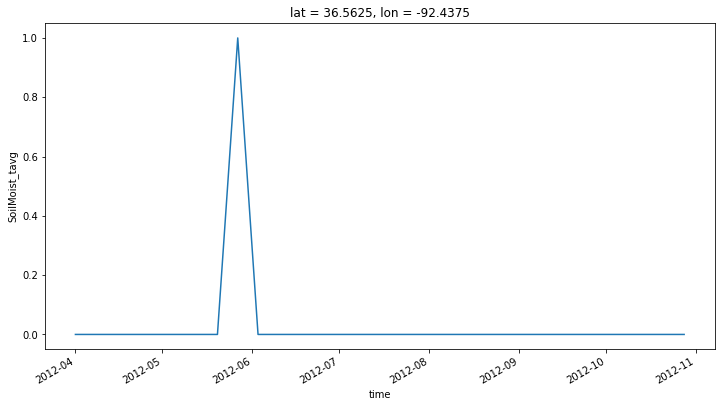

In [63]:
binary_onset.sel(lon=-92.4375,lat=36.5625, time=slice('2012-04-01T00:00:00.000000000','2012-10-31T00:00:00.000000000')).plot(aspect=2, size=6)
#binary_sev.sel(lon=-92.4375,lat=36.5625, time=slice('2012-04-01T00:00:00.000000000','2012-10-31T00:00:00.000000000')).plot(aspect=2, size=6)


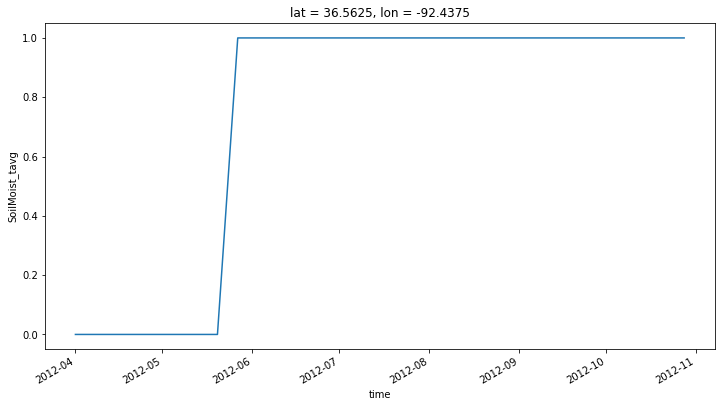

In [19]:
#test if fd has no duration

binary.sel(lon=-92.4375,lat=36.5625, time=slice('2012-04-01T00:00:00.000000000','2012-10-31T00:00:00.000000000')).plot(aspect=2, size=6)
#binary_sev.sel(lon=-92.4375,lat=36.5625, time=slice('2012-04-01T00:00:00.000000000','2012-10-31T00:00:00.000000000')).plot(aspect=2, size=6)


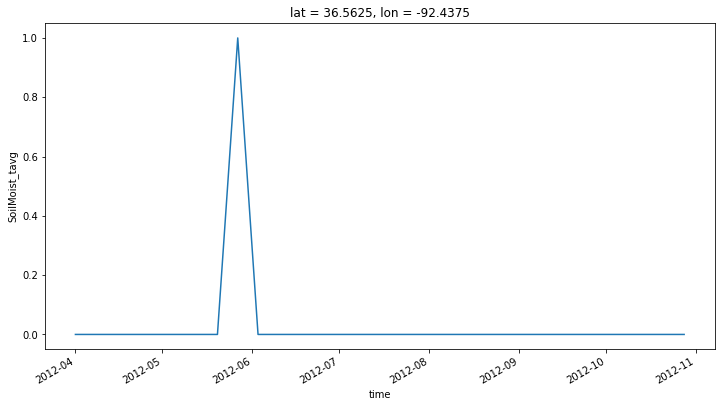

In [64]:
binary_onset.sel(lon=-92.4375,lat=36.5625, time=slice('2012-04-01T00:00:00.000000000','2012-10-31T00:00:00.000000000')).plot(aspect=2, size=6)


In [81]:
binary_onset_20.sel(lon=-92.4375,lat=36.5625, time=slice('2012-04-01T00:00:00.000000000','2012-10-31T00:00:00.000000000')).plot(aspect=2, size=6)


NameError: name 'binary_onset_20' is not defined

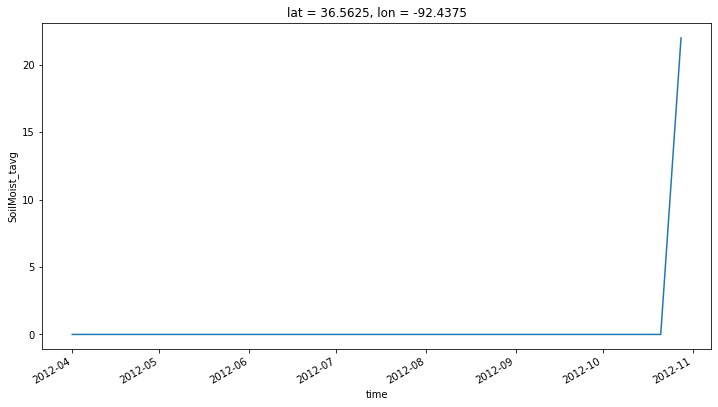

In [101]:
binary_dur.sel(lon=-92.4375,lat=36.5625, time=slice('2012-04-01T00:00:00.000000000','2012-10-31T00:00:00.000000000')).plot(aspect=2, size=6)


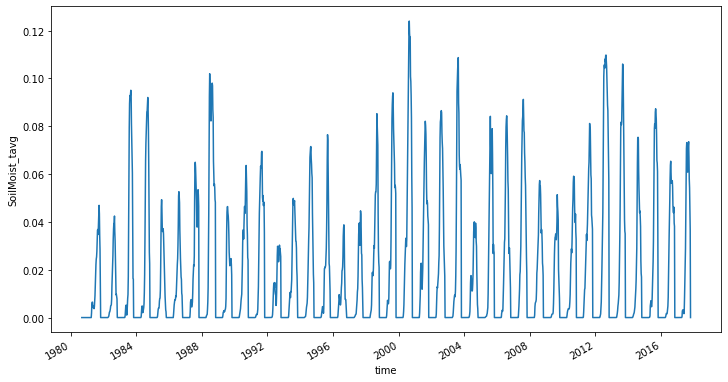

In [20]:
#test
binary.mean(dim=["lon","lat"]).plot(aspect=2, size=6,label="DA")


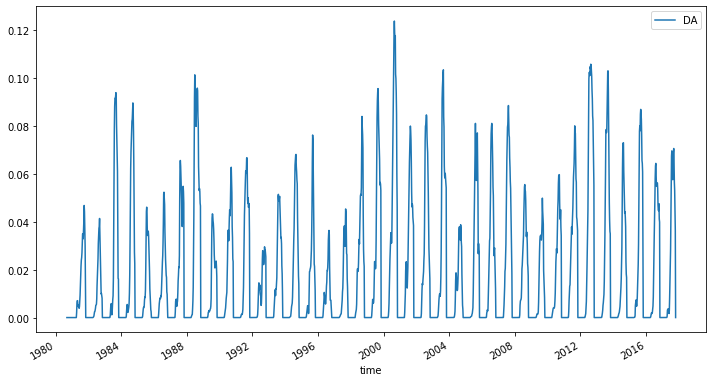

In [21]:
weights = np.cos(np.deg2rad(binary.lat))
weights.name = "weights"
air_weighted_DA = binary.weighted(weights)
#air_weighted_OL = Binary_OL_17_Gr.weighted(weights)

air_weighted_DA.mean(dim=["lon","lat"]).plot(aspect=2, size=6,label="DA")
#air_weighted_OL.mean(dim=["lon","lat"]).plot(label="OL")

plt.legend()

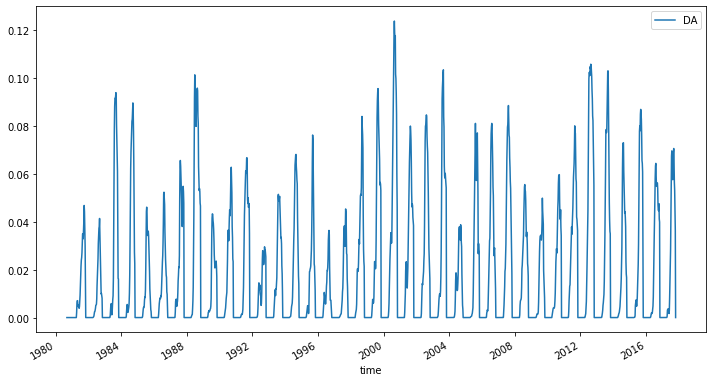

In [22]:
#recently produced 
weights = np.cos(np.deg2rad(binary.lat))
weights.name = "weights"
air_weighted_DA = binary.weighted(weights)
#air_weighted_OL = Binary_OL_17_Gr.weighted(weights)

air_weighted_DA.mean(dim=["lon","lat"]).plot(aspect=2, size=6,label="DA")
#air_weighted_OL.mean(dim=["lon","lat"]).plot(label="OL")

plt.legend()

In [21]:
#First get rid of zero durations! 
Binary_dur2 = binary_dur.where(binary_dur !=0, drop=True) 
Binary_dur2 = Binary_dur2.where(Binary_dur2 !=1, drop=True)   

Binary_dur2.plot.hist()   #ax=axs[1]



NameError: name 'binary_dur' is not defined

In [102]:
Binary_dur2.mean(["lon","lat"]).plot.hist()   #ax=axs[1]


NameError: name 'Binary_dur2' is not defined

In [115]:
Binary_dur2.min()

<xarray.DataArray 'SoilMoist_tavg' ()>
array(2.)

In [106]:

# Do not remove! 
#binary.to_netcdf('/glade/work/afallah/data/binary_DA_198009_new_way_weekly10.nc', mode='w')   #could be ...truncated if only consider the rapid intensification period 
#binary.to_netcdf('/glade/work/afallah/data/binary_OL_198009_new_way_weekly10.nc', mode='w')

#binary_sev.to_netcdf('/glade/work/afallah/data/binary_sev_DA_198009_new_way_weekly10.nc', mode='w')
#binary_sev.to_netcdf('/glade/work/afallah/data/binary_sev_OL_198009_new_way_weekly10.nc', mode='w')

#binary_onset.to_netcdf('/glade/work/afallah/data/binary_onset_DA_198009_new_way_weekly10.nc', mode='w')
#binary_onset.to_netcdf('/glade/work/afallah/data/binary_onset_OL_198009_new_way_weekly10.nc', mode='w')

#binary_onset_drought.to_netcdf('/glade/work/afallah/data/binary_onset_drought_DA_198009_new_way_weekly10.nc', mode='w')
#binary_onset_drought.to_netcdf('/glade/work/afallah/data/binary_onset_drought_OL_198009_new_way_weekly10.nc', mode='w')

#binary_dur.to_netcdf('/glade/work/afallah/data/binary_dur_DA_198009_new_way_weekly10.nc', mode='w')
binary_dur.to_netcdf('/glade/work/afallah/data/binary_dur_OL_198009_new_way_weekly10.nc', mode='w')


In [17]:
#test
binary = xr.open_dataset('/glade/work/afallah/data/binary_OL_198009_new_way_weekly10.nc')
binary = binary.SoilMoist_tavg

(array([2.78261e+05, 1.23211e+05, 7.16410e+04, 3.97270e+04, 4.37260e+04,
        1.77550e+04, 6.05100e+03, 4.56800e+03, 7.95000e+02, 1.18000e+02]),
 array([ 2. ,  4.7,  7.4, 10.1, 12.8, 15.5, 18.2, 20.9, 23.6, 26.3, 29. ]),
 <BarContainer object of 10 artists>)

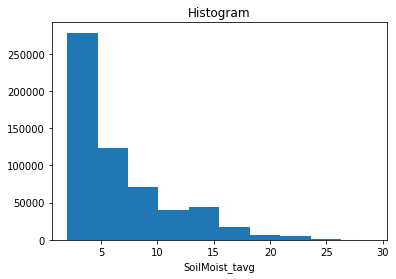

In [116]:
#test
Binary_dur0 = binary_dur.where(binary_dur !=0, drop=True) 

Binary_dur0.plot.hist()   #ax=axs[1]


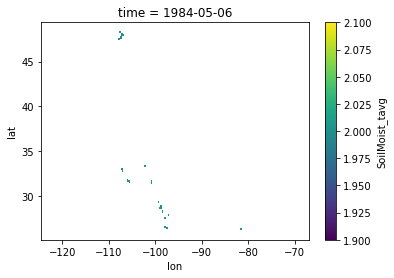

In [117]:
#test
#Binary_dur0.min()
Binary_dur0.isel(time=80).where(Binary_dur0.isel(time=80) == 2).plot()

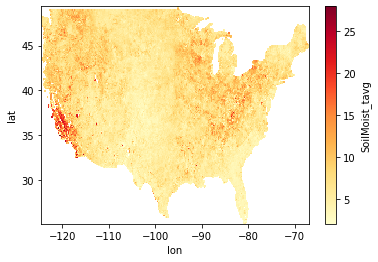

In [107]:
#test
Binary_dur0.mean(dim='time').plot(cmap='YlOrRd')

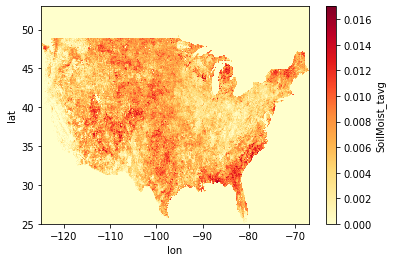

In [108]:
#test
binary_onset_20.mean(dim='time').plot(cmap='YlOrRd')

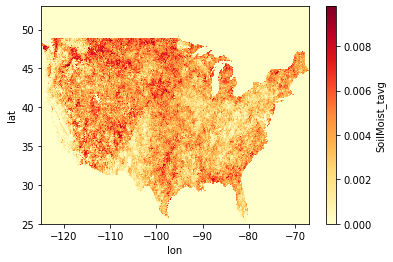

In [109]:
#test
binary_onset_drought.mean(dim='time').plot(cmap='YlOrRd')

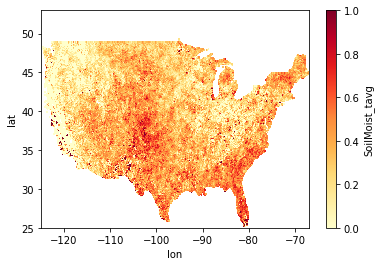

In [110]:
#test
a = binary_onset_20.mean(dim='time')
b = binary_onset_drought.mean(dim='time')
(1-b/a).plot(cmap='YlOrRd')

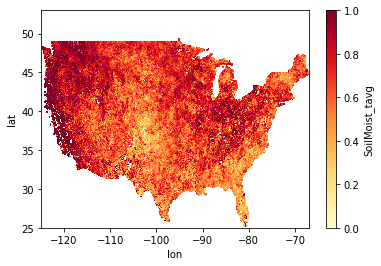

In [111]:
#test
a = binary_onset_20.mean(dim='time')
b = binary_onset_drought.mean(dim='time')
(b/a).plot(cmap='YlOrRd')

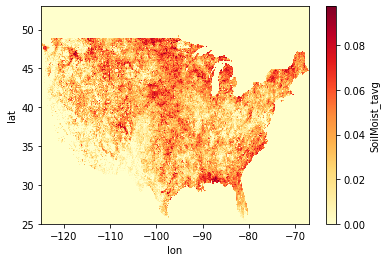

In [118]:

binary.mean(dim='time').plot(cmap='YlOrRd')

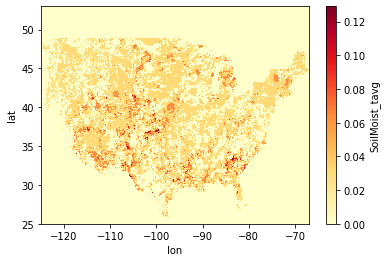

In [141]:
binary_onset_20.sel(time=slice('2012-04-01T00:00:00.000000000','2012-10-31T00:00:00.000000000')).mean(dim='time').plot(cmap='YlOrRd')

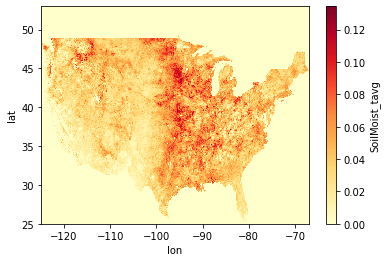

In [118]:
binary_sev_norm.mean(dim='time').plot(cmap='YlOrRd')

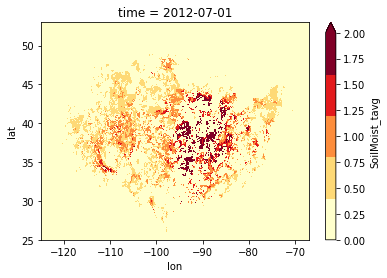

In [120]:
import matplotlib.cm as cm
cmap2 = cm.get_cmap("YlOrRd",lut=5)
cmap2.set_under("k")

binary_sev_norm.sel(time='2012-07-01T00:00:00.000000000').plot(vmin=0,vmax=2,cmap=cmap2)

In [67]:
binary_onset_yearly = binary_onset.resample(time="Y").sum()


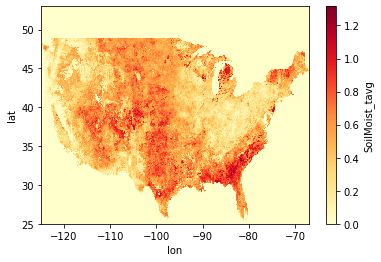

In [68]:
binary_onset_yearly.mean(dim="time").plot(cmap='YlOrRd')    ##this shows frequency

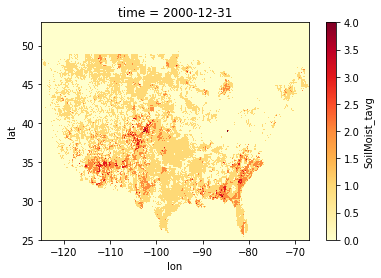

In [69]:
binary_onset_yearly.isel(time=20).plot(cmap='YlOrRd')   #Whole year 2000    #this shows total frequency in each year

In [118]:
#assign 1 for each each year with at least one FD event

binary_onset_20_yearly = binary_onset_20.resample(time="Y").sum()
a = binary_onset_20_yearly
b = xr.where(a >= 1, 1, 0) 

In [121]:
binary_onset_20_yearly.sel(lon=-100.9375,lat=39.0625)

<xarray.DataArray 'SoilMoist_tavg' (time: 38)>
array([0., 0., 0., 1., 2., 1., 1., 1., 3., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 1., 2., 1., 0., 1., 2., 0., 0., 0., 1., 1., 0.,
       0., 1., 0., 1.])
Coordinates:
  * time     (time) datetime64[ns] 1980-12-31 1981-12-31 ... 2017-12-31
    lat      float64 39.06
    lon      float64 -100.9

In [122]:
b.sel(lon=-100.9375,lat=39.0625)

<xarray.DataArray 'SoilMoist_tavg' (time: 38)>
array([0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1])
Coordinates:
  * time     (time) datetime64[ns] 1980-12-31 1981-12-31 ... 2017-12-31
    lat      float64 39.06
    lon      float64 -100.9

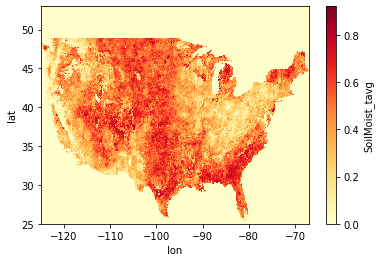

In [123]:
b.mean(dim="time").plot(cmap='YlOrRd')    ##this shows frequency


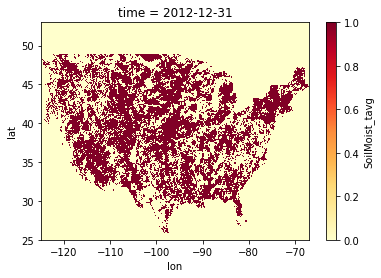

In [144]:
b.isel(time=32).plot(cmap='YlOrRd')    ##this shows frequency


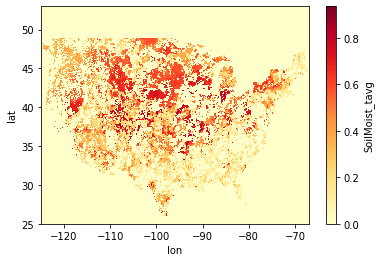

In [14]:
binary.sel(time=slice('2012-04-01T00:00:00.000000000','2012-10-31T00:00:00.000000000')).mean(dim='time').plot(cmap='YlOrRd')

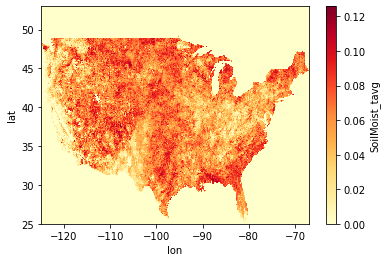

In [15]:
binary.mean(dim='time').plot(cmap='YlOrRd')

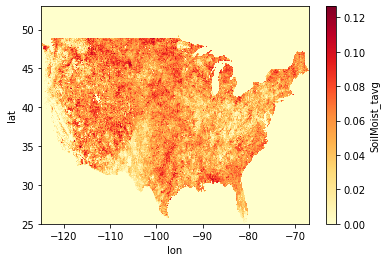

In [20]:
#recent with above 40% 
binary.mean(dim='time').plot(cmap='YlOrRd')


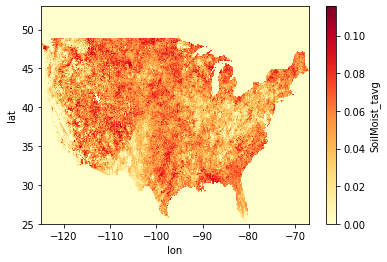

In [15]:
binary_dur.mean(dim='time').plot(cmap='YlOrRd')

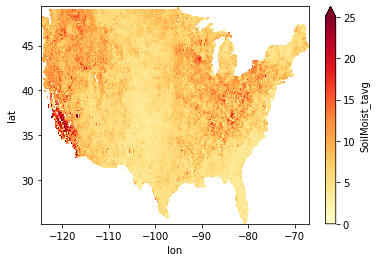

In [36]:
#Drop zero values in cacluating duration ave.
ds2 = binary_dur.where(binary_dur !=0, drop=True)   

ds2.mean(dim='time').plot(cmap='YlOrRd',vmin=0,vmax=25)

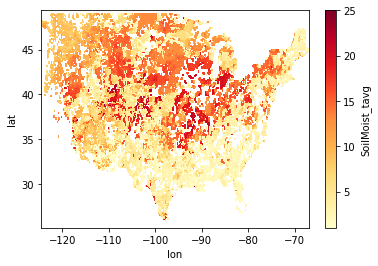

In [23]:
ds2.sel(time=slice('2012-04-01T00:00:00.000000000','2012-10-31T00:00:00.000000000')).mean(dim='time').plot(cmap='YlOrRd')

In [94]:
binary_dur.sel(lon=-92.4375,lat=36.5625)[1000:2000]

<xarray.DataArray 'SoilMoist_tavg' (time: 939)>
array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 11.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
...
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  7.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0., 10.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 12.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.])
Coordinates:
    lat      float64 36.56
    lon      float64 -92.44
  * time     (time) datetime64[ns] 1999-11-07 1999-11-14 ... 2017-10-29

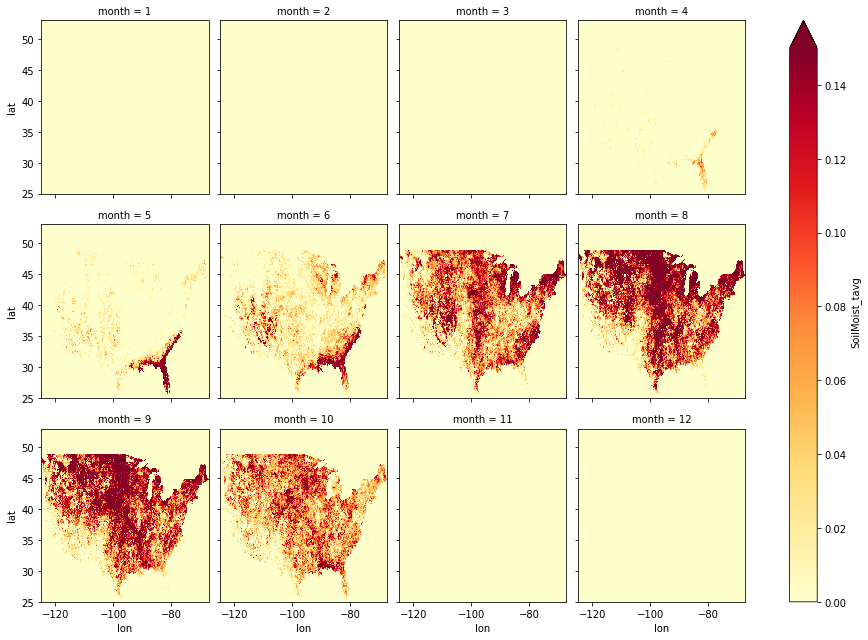

In [14]:
data1 = binary.groupby('time.month').mean(dim='time')

# Plot the output
data1.plot(col='month', col_wrap=4,vmin=0, vmax=.15, cmap='YlOrRd')
plt.show()

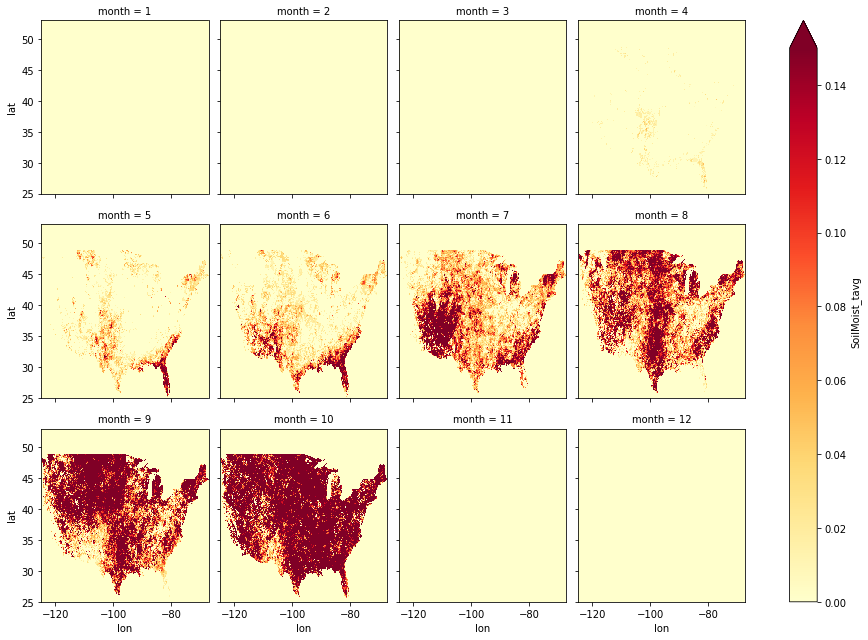

In [35]:
data1 = binary_dur.groupby('time.month').mean(dim='time')

# Plot the output
data1.plot(col='month', col_wrap=4,vmin=0, vmax=.15, cmap='YlOrRd')
plt.show()

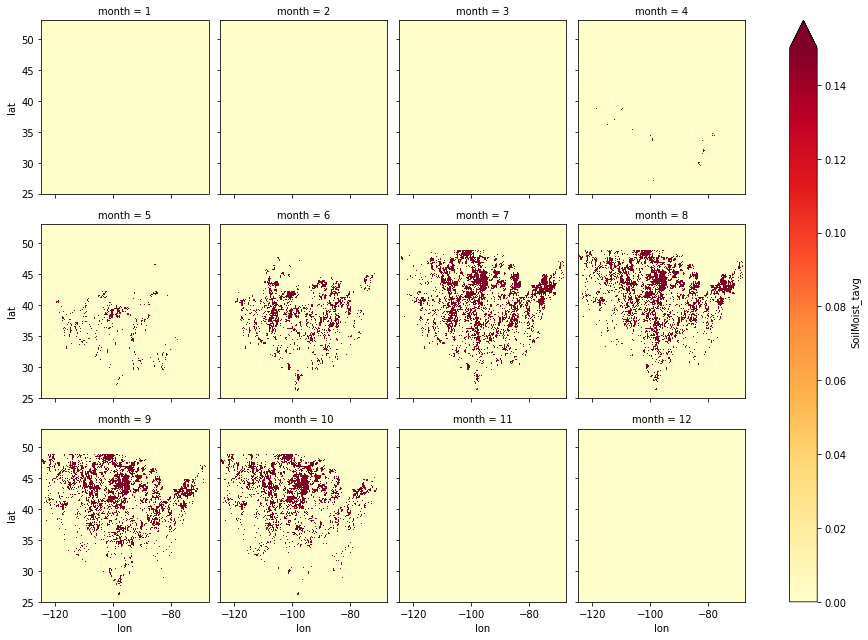

In [15]:
binary_2012 = binary.sel(time=slice('2012-01-01T00:00:00.000000000','2012-12-31T00:00:00.000000000'))

data1 =binary_2012.groupby('time.month').mean(dim='time')

# Plot the output
data1.plot(col='month', col_wrap=4,vmin=0, vmax=.15, cmap='YlOrRd')
plt.show()

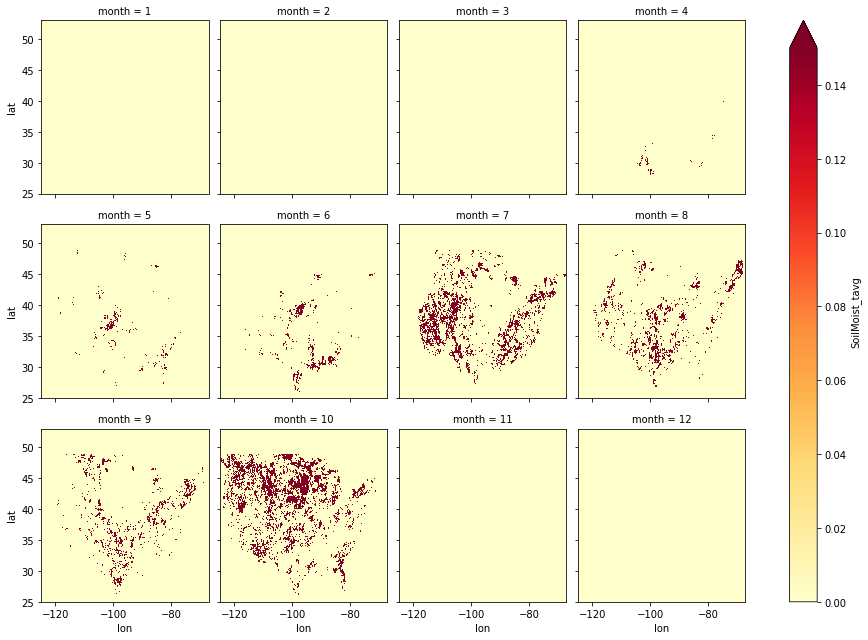

In [38]:
binary_2012 = binary_dur.sel(time=slice('2012-01-01T00:00:00.000000000','2012-12-31T00:00:00.000000000'))

data1 =binary_2012.groupby('time.month').mean(dim='time')

# Plot the output
data1.plot(col='month', col_wrap=4,vmin=0, vmax=.15, cmap='YlOrRd')
plt.show()

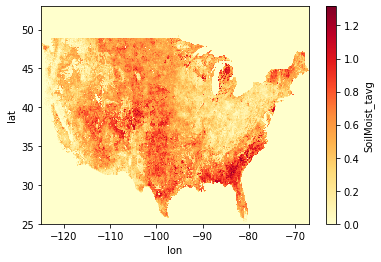

In [124]:
binary_onset_20_yearly.mean(dim="time").plot(cmap='YlOrRd')    ##this shows frequency

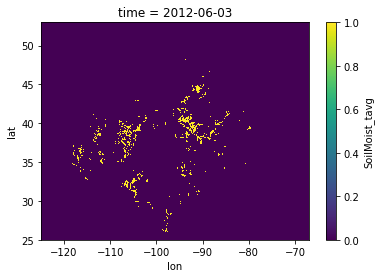

In [76]:
binary_onset_20.isel(time=1656).plot()

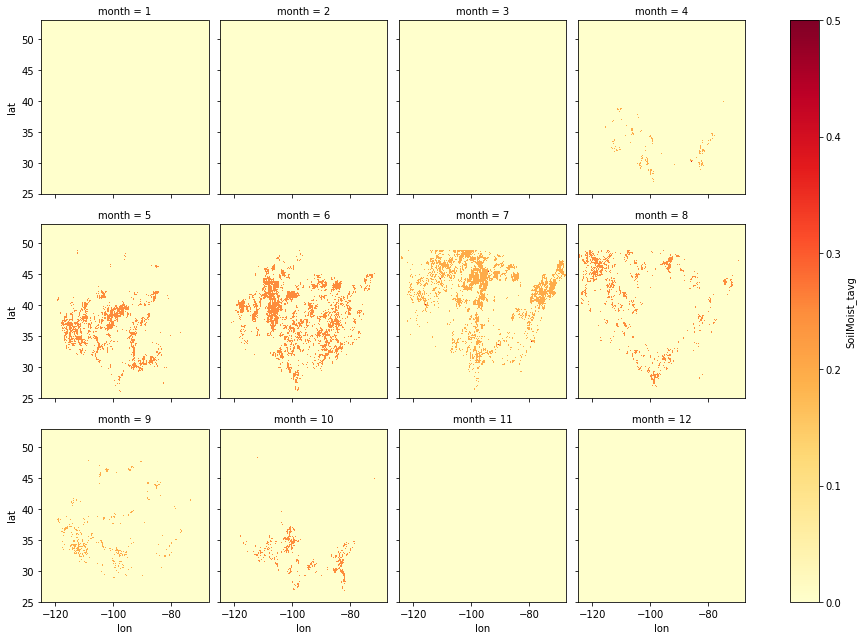

In [68]:
da_2012 = binary_onset_20.sel(time=slice('2012-01-01T00:00:00.000000000','2012-12-31T00:00:00.000000000'))

data1 =da_2012.groupby('time.month').mean(dim='time')

# Plot the output
data1.plot(col='month', col_wrap=4, cmap='YlOrRd')
plt.show()

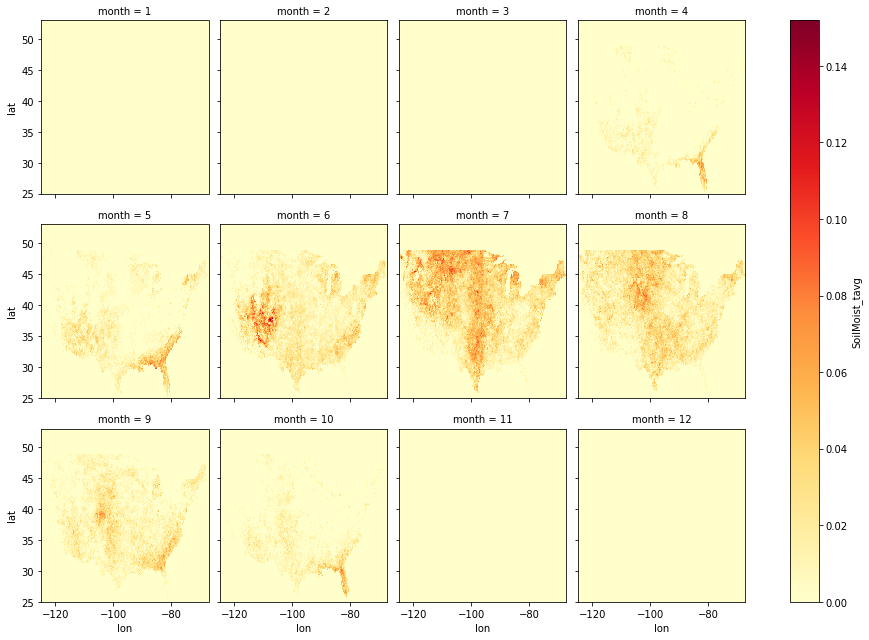

In [69]:


data1 =binary_onset_20.groupby('time.month').mean(dim='time')

# Plot the output
data1.plot(col='month', col_wrap=4, cmap='YlOrRd')
plt.show()

In [93]:
binary_yearly = binary.resample(time="Y").sum()


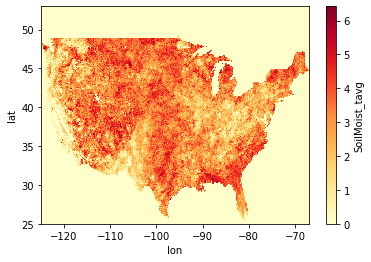

In [137]:
binary_yearly.mean(dim="time").plot(cmap='YlOrRd')    ##this shows duration

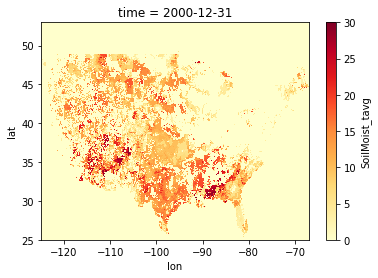

In [138]:
binary_yearly.isel(time=20).plot(cmap='YlOrRd')   #Whole year 2000    #this shows total duration in each year

In [107]:
binary_sev_yearly = binary_sev_norm.resample(time="Y").sum()


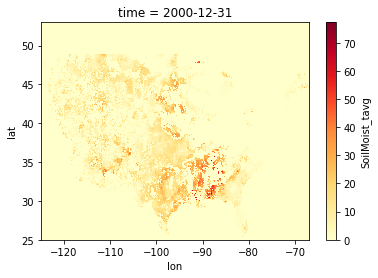

In [139]:
binary_sev_yearly.isel(time=20).plot(cmap='YlOrRd')   #Whole year 2000    #this shows total severity in each year

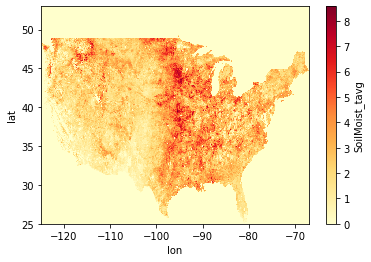

In [140]:
binary_sev_yearly.mean(dim="time").plot(cmap='YlOrRd')    ##this shows severity

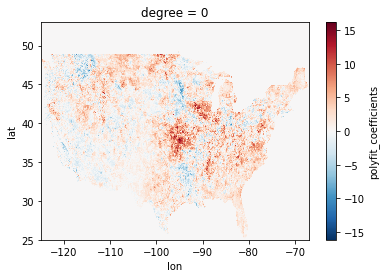

In [142]:
trend = binary_sev_yearly.polyfit("time",deg=1)
trend.polyfit_coefficients.sel(degree=0).plot()   #grap the slop (fitst element) not sure!    #.polyfit_coefficients is a variable here!


In [4]:
data2_DA=xr.open_mfdataset("/glade/scratch/afallah/NLDAS_Files/DA/LIS*.nc", parallel=True)    #16min; reduced using parallel to 10 min
SM_DA = data2_DA.SoilMoist_tavg.mean('SoilMoist_profiles')

SM_DA = SM_DA.sel(time=SM_DA.time.dt.month.isin([4, 5, 6, 7, 8, 9, 10])) 

In [5]:
SM_DA = SM_DA.load() 

In [222]:
data1 = SM_DA.groupby('time.week').mean(dim='time')     
SM_ano = SM_DA.groupby('time.week') - data1

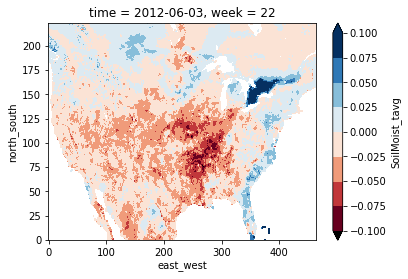

In [223]:
import matplotlib.cm as cm
cmap2 = cm.get_cmap("RdBu",lut=8)
cmap2.set_under("k")

SM_ano.isel(time=7125).plot(cmap=cmap2,vmin=-0.1,vmax=0.1)

In [2]:
data2_OL=xr.open_mfdataset("/glade/scratch/afallah/NLDAS_Files/OL/LIS*.nc", parallel=True)    #16min; reduced using parallel to 10 min
SM_OL = data2_OL.SoilMoist_tavg.mean('SoilMoist_profiles')

SM_OL = SM_OL.sel(time=SM_OL.time.dt.month.isin([4, 5, 6, 7, 8, 9, 10])) 

In [3]:
SM_OL = SM_OL.load() 

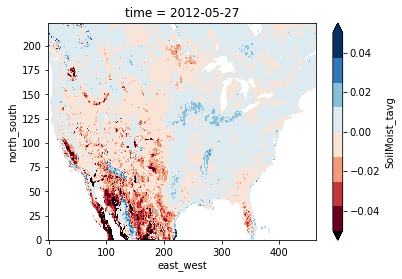

In [28]:
import matplotlib.cm as cm
cmap2 = cm.get_cmap("RdBu",lut=8)
cmap2.set_under("k")

a= SM_DA.isel(time=7118)
b= SM_OL.isel(time=7118)
(a-b).plot(cmap=cmap2,vmin=-0.05,vmax=0.05)

In [9]:
LAI_DA = data2_DA.LAI_tavg
LAI_DA = LAI_DA.sel(time=LAI_DA.time.dt.month.isin([4, 5, 6, 7, 8, 9, 10])) 

In [10]:
LAI_DA = LAI_DA.load() 

In [11]:
LAI_OL = data2_OL.LAI_tavg
LAI_OL = LAI_OL.sel(time=LAI_OL.time.dt.month.isin([4, 5, 6, 7, 8, 9, 10])) 

In [12]:
LAI_OL = LAI_OL.load() 

In [ ]:
data1 = LAI_DA.groupby('time.week').mean(dim='time')     
LAI_DA_ano = LAI_DA.groupby('time.week') - data1

In [ ]:
import matplotlib.cm as cm
cmap2 = cm.get_cmap("BrBG",lut=6)
cmap2.set_under("k")

LAI_DA_ano.isel(time=7125).plot(cmap=cmap2,vmin=-1.5,vmax=1.5)

In [213]:
data2_DA

<xarray.Dataset>
Dimensions:           (SoilMoist_profiles: 4, east_west: 464, north_south: 224, time: 14245)
Coordinates:
  * time              (time) datetime64[ns] 1979-01-03 1979-01-04 ... 2018-01-02
Dimensions without coordinates: SoilMoist_profiles, east_west, north_south
Data variables:
    lat               (time, north_south, east_west) float32 dask.array<chunksize=(1, 224, 464), meta=np.ndarray>
    lon               (time, north_south, east_west) float32 dask.array<chunksize=(1, 224, 464), meta=np.ndarray>
    Qle_tavg          (time, north_south, east_west) float32 dask.array<chunksize=(1, 224, 464), meta=np.ndarray>
    Qh_tavg           (time, north_south, east_west) float32 dask.array<chunksize=(1, 224, 464), meta=np.ndarray>
    Qg_tavg           (time, north_south, east_west) float32 dask.array<chunksize=(1, 224, 464), meta=np.ndarray>
    Evap_tavg         (time, north_south, east_west) float32 dask.array<chunksize=(1, 224, 464), meta=np.ndarray>
    Qs_tavg           (time, north_south, east_west) float32 dask.array<chunksize=(1, 224, 464), meta=np.ndarray>
    Qsb_tavg          (time, north_south, east_west) float32 dask.array<chunksize=(1, 224, 464), meta=np.ndarray>
    RadT_tavg         (time, north_south, east_west) float32 dask.array<chunksize=(1, 224, 464), meta=np.ndarray>
    Albedo_tavg       (time, north_south, east_west) float32 dask.array<chunksize=(1, 224, 464), meta=np.ndarray>
    SWE_tavg          (time, north_south, east_west) float32 dask.array<chunksize=(1, 224, 464), meta=np.ndarray>
    SnowDepth_tavg    (time, north_south, east_west) float32 dask.array<chunksize=(1, 224, 464), meta=np.ndarray>
    SoilMoist_tavg    (time, SoilMoist_profiles, north_south, east_west) float32 dask.array<chunksize=(1, 4, 224, 464), meta=np.ndarray>
    WaterTableD_tavg  (time, north_south, east_west) float32 dask.array<chunksize=(1, 224, 464), meta=np.ndarray>
    TWS_tavg          (time, north_south, east_west) float32 dask.array<chunksize=(1, 224, 464), meta=np.ndarray>
    GWS_tavg          (time, north_south, east_west) float32 dask.array<chunksize=(1, 224, 464), meta=np.ndarray>
    Snowcover_tavg    (time, north_south, east_west) float32 dask.array<chunksize=(1, 224, 464), meta=np.ndarray>
    GPP_tavg          (time, north_south, east_west) float32 dask.array<chunksize=(1, 224, 464), meta=np.ndarray>
    NPP_tavg          (time, north_south, east_west) float32 dask.array<chunksize=(1, 224, 464), meta=np.ndarray>
    NEE_tavg          (time, north_south, east_west) float32 dask.array<chunksize=(1, 224, 464), meta=np.ndarray>
    LAI_tavg          (time, north_south, east_west) float32 dask.array<chunksize=(1, 224, 464), meta=np.ndarray>
    Greenness_tavg    (time, north_south, east_west) float32 dask.array<chunksize=(1, 224, 464), meta=np.ndarray>
Attributes:
    missing_value:           -9999.0
    NUM_SOIL_LAYERS:         4
    SOIL_LAYER_THICKNESSES:  [0.1 0.3 0.6 1. ]
    title:                   LIS land surface model output
    institution:             NASA GSFC
    source:                  NoahMP.3.6
    history:                 created on date: 2018-10-03T05:09:05.025
    references:              Kumar_etal_EMS_2006, Peters-Lidard_etal_ISSE_2007
    conventions:             CF-1.6
    comment:                 website: http://lis.gsfc.nasa.gov/
    MAP_PROJECTION:          EQUIDISTANT CYLINDRICAL
    SOUTH_WEST_CORNER_LAT:   25.0625
    SOUTH_WEST_CORNER_LON:   -124.9375
    DX:                      0.125
    DY:                      0.125

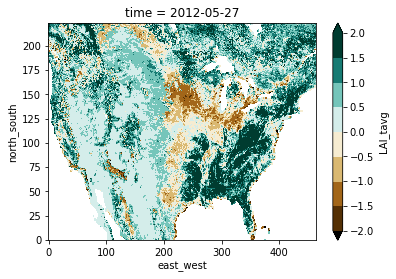

In [29]:
import matplotlib.cm as cm
cmap2 = cm.get_cmap("BrBG",lut=8)
cmap2.set_under("k")

a= LAI_DA.isel(time=7118)
b= LAI_OL.isel(time=7118)
(a-b).plot(cmap=cmap2,vmin=-2,vmax=2)


In [104]:
DA = data2.SoilMoist_tavg.mean('SoilMoist_profiles')

DA = DA.sel(time=DA.time.dt.month.isin([4, 5, 6, 7, 8, 9, 10]))        
DA5 = DA.resample(time="7d").mean()


lat = data2.north_south
lon = data2.east_west

#DA5_US = DA5.sel(east_west=slice(230,300),north_south=slice(25,50),time=slice("1979-01-01","1980-01-01"))   #only 5 years   #change later 1 to 5!  #5min
#DA5_US = DA5.sel(east_west=slice(230,300),north_south=slice(25,50),time=slice("1979-01-01","1988-01-01"))   #only 5 years   #change later 1 to 5!  #5min
#DA5_US = DA5.sel(east_west=slice(130,460),north_south=slice(15,200),time=slice("1981-01-01","2017-01-01"))   #only 5 years   #change later 1 to 5!  #5min

DA5_US = DA5.sel(east_west=slice(200,350),north_south=slice(75,150),time=slice("1980-09-01","2017-10-28"))   #east_west=slice(30,460),north_south=slice(10,200),






In [108]:
DA5_US_point = DA5_US.load() 


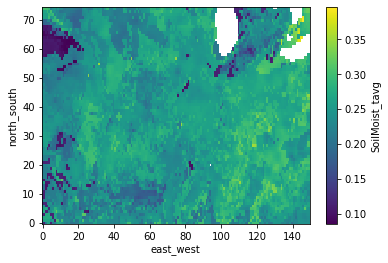

In [111]:
DA5_US_point.sel(time=slice('2012-04-01T00:00:00.000000000','2012-10-30T00:00:00.000000000')).mean(dim="time").plot()

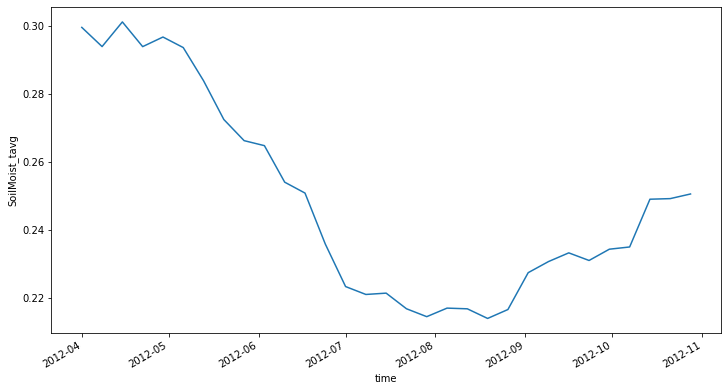

In [109]:
a = DA5_US_point.sel(time=slice('2012-04-01T00:00:00.000000000','2012-10-30T00:00:00.000000000')).mean(dim=("east_west","north_south"))

a.plot(aspect=2, size=6, label="DA")

In [121]:
binary_midwest = binary.sel(lon=slice(-95,-75),lat=slice(37,45))

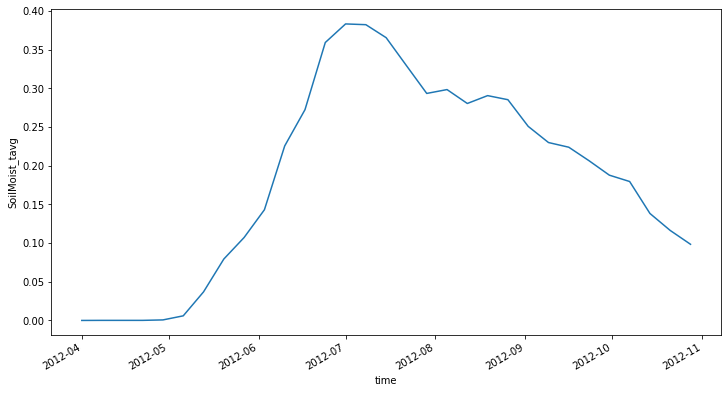

In [122]:
a = binary_midwest.sel(time=slice('2012-04-01T00:00:00.000000000','2012-10-30T00:00:00.000000000')).mean(dim=("lon","lat"))

a.plot(aspect=2, size=6, label="DA")




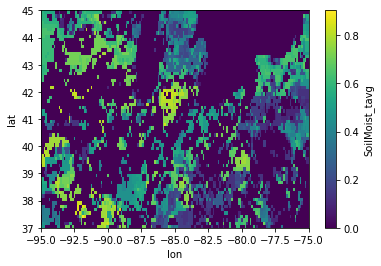

In [123]:
binary_midwest.sel(time=slice('2012-04-01T00:00:00.000000000','2012-10-30T00:00:00.000000000')).mean(dim="time").plot()